In [15]:
from utils import *
from install_requirement import *

 # Q2

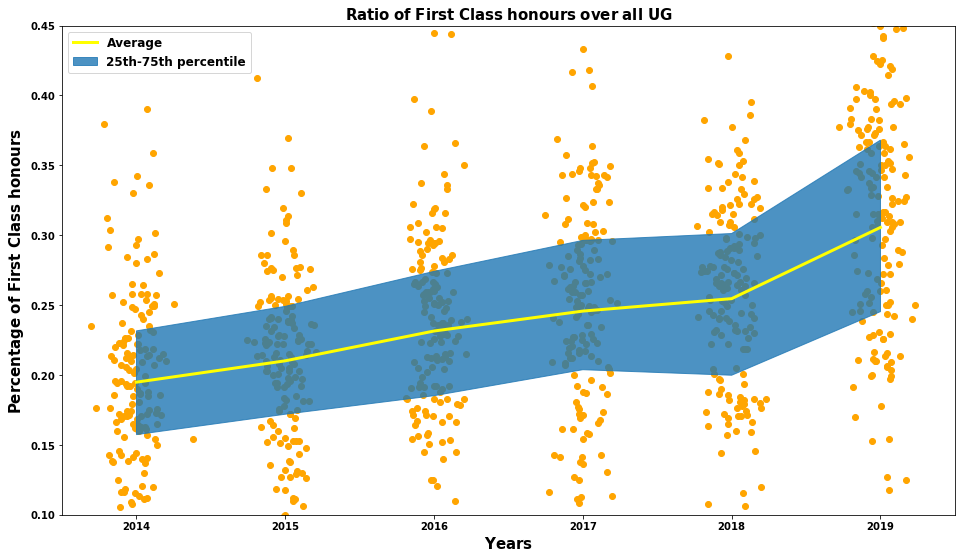

In [19]:
#(25 th percentile, 75 th percentile)
percentiles = {}
avgs = []
p25s = []
p75s = []

for year, dataset in degree_class_ratio_by_years.items():
    p25s.append(np.percentile(dataset["First class honours"],25))
    p75s.append(np.percentile(dataset["First class honours"],75))
    avgs.append(np.mean(dataset["First class honours"]))

fig, ax = plt.subplots(figsize=(16,9))

# draw each point with offset
for year,dataset in degree_class_ratio_by_years.items():
    ax.scatter(  
        list(map(add , [year] * len(dataset), np.random.randn(len(dataset))/10 )), \
        dataset["First class honours"], \
        c = 'orange',  )

# color area between 25th and 75th percentile
ax.fill( years + list(reversed(years)), p25s + list(reversed(p75s)),
         label='25th-75th percentile', alpha = 0.8, c='tab:blue')
# plot average 
ax.plot(years, avgs, label='Average',
        color='yellow', linewidth=3 )

ax.legend(prop={'size': 12})
ax.set_title(r"$\mathbf{Ratio \; of \; First \; Class \; honours \; over \; all \ UG}$", fontsize=15)
ax.set_ylim(0.1,0.45)
ax.set_xlim((years[0]-0.5,years[-1]+0.5))
ax.set_xlabel(r"$\mathbf{Years}$", fontsize=15)
ax.set_ylabel(r"$\mathbf{Percentage \; of \; First \ Class \ honours}$", fontsize=15)
rc('font', weight='bold')
plt.show()

 #### X variable:
   - university entry requirement
   - location (england=0, scotland=1, wales=2, northern_ireland=3)
   - academic investment
   - facilities investment
   - year

 #### Y variable:
   - first class degree ratio

 Match the name of university to its location, entry score, acdamic investments, facalities investments and first class ratio.

In [6]:
mr_df = pd.DataFrame(columns=['Name', 'Year', 'Entry score', 'Academic invest', 'Facility invest', 'Country', 'First Class Rate', 'First degree'])

df_index = 0
for year in years:
    x = degree_class_ratio_by_years[year]
    for _,row in uni_geocode.iterrows():
        if (row['Name'].replace('The ','') in uni_ranking) and\
            len(x[x['HE provider'] == row['Name']]['First class honours']) == 1:
            index = uni_ranking.index(row['Name'].replace('The ',''))
            name = row['Name']
            entry = entry_score_raw[index]
            academic = academic_invest_raw[index]
            facility = facility_invest_raw[index]
            country = reverseGeocode((row['Latitude'], row['Longitude']))
            ratio = float(x[x['HE provider'] == row['Name']]['First class honours'])
            first_deg = x[x['HE provider'] == row['Name']]['First degree']
            mr_df.loc[df_index] = [name, year, entry, academic, facility, country, ratio, int(first_deg)]
            df_index += 1
        pass

 Run multiple linear regression and make prediction.

In [7]:
y = mr_df['First Class Rate']
X = mr_df[['Year', 'Entry score', 'Academic invest', 'Facility invest', 'Country']].astype(float)
reg = linear_model.LinearRegression().fit(X, y)
ypred = reg.predict(X)

 Calculate confidence interval
 CI = sample mean +- confidence level value * sample std dev / sqrt(sample size)

In [8]:
conf_level_val = 0.95
temp = conf_level_val * np.std(ypred,ddof=len(ypred)-1) / np.sqrt(len(ypred))
print(round(np.mean(ypred) + temp, 3))
print(round(np.mean(ypred) - temp, 3))

0.287
0.204


In [9]:
stats.summary(reg, X, y,  ['Year', 'Entry score', 'Academic invest', 'Facility invest', 'Country', ])

Residuals:
    Min      1Q  Median      3Q     Max
-0.2163 -0.0332 -0.0014  0.0327  0.1894


Coefficients:
                  Estimate  Std. Error     t value   p value
_intercept      -45.091367    2.516912    -17.9154  0.000000
Year              0.022427    0.000002  11365.1015  0.000000
Entry score       0.001260    0.000183      6.8710  0.000000
Academic invest   0.000607    0.000160      3.7940  0.000162
Facility invest   0.000081    0.000151      0.5383  0.590518
Country          -0.011074    0.002831     -3.9120  0.000101
---
R-squared:  0.38327,    Adjusted R-squared:  0.37868
F-statistic: 83.52 on 5 features


 Compute mean of prediction by year.

In [10]:
y_pred_avg = []
y_avg = []
for year in years:
    init_index = X[X['Year'] == year].index[0]
    tail_index = X[X['Year'] == year].index[-1]
    y_pred_avg.append(np.mean(ypred[init_index:tail_index+1]))
    y_avg.append(np.mean(y[init_index:tail_index+1]))


 Draw prediction

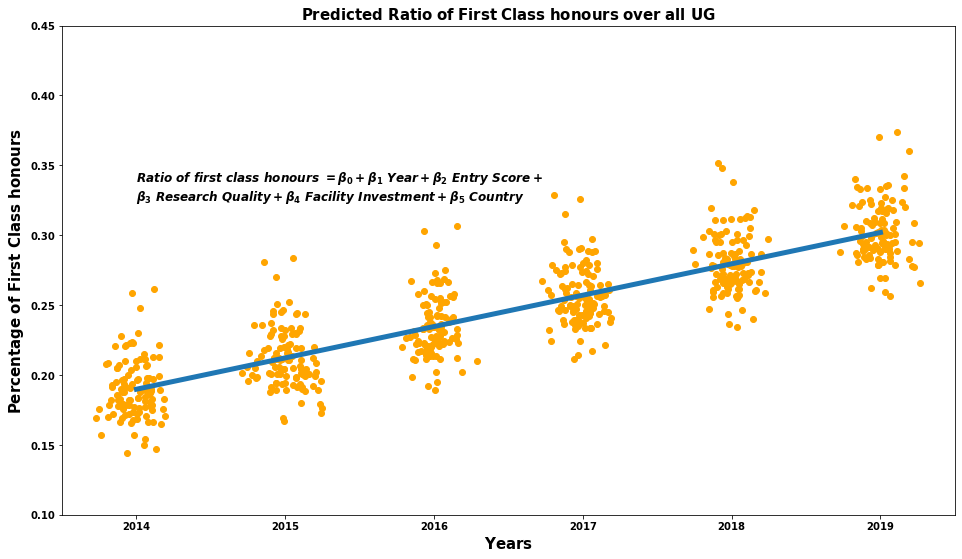

In [11]:
fig, ax = plt.subplots(figsize=(16,9))

# draw each point with offset
for year in years:
    init_index = X[X['Year'] == year].index[0]
    tail_index = X[X['Year'] == year].index[-1]
    ypred_this_year = ypred[init_index:tail_index+1]
    ax.scatter(  
        list(map(add , [year] * len(ypred_this_year), np.random.randn(len(ypred_this_year))/10 )), \
        ypred_this_year, c = 'orange' )

# plot average 
ax.plot(years, y_pred_avg, 
        color='tab:blue', 
        linewidth=5 )

# write formula
msg = (r"$Ratio\ of\ first\ class \ honours \ = "
       r"\beta_{0} +"
       r"\beta_{1} \ Year  +"
       r"\beta_{2} \ Entry \ Score +"
       r"$" "\n"
       r"$\beta_{3} \ Research \ Quality +"
       r"\beta_{4} \ Facility \ Investment+"
       r"\beta_{5} \ Country"
       r"$")
plt.text(2014, 0.325, msg,size=12)

ax.set_title(r"$\mathbf{Predicted \ Ratio \; of \; First \; Class \; honours \; over \; all \ UG}$", fontsize=15)
ax.set_ylim(0.1,0.45)
ax.set_xlim((years[0]-0.5,years[-1]+0.5))
ax.set_xlabel(r"$\mathbf{Years}$", fontsize=15)
ax.set_ylabel(r"$\mathbf{Percentage \; of \; First \ Class \ honours}$", fontsize=15)
rc('font', weight='bold')
plt.show()

# Q4 Part 2

In [12]:
mr_df['First Class Rate Pred'] = ypred
mr_df['pred dev'] = [ a - b for a,b in zip(y,ypred)]

In [30]:
tiers = []
tiers.append(mr_df[mr_df['First degree'] < 1000])
tiers.append(mr_df[(mr_df['First degree'] < 5000) & (mr_df['First degree'] > 1000)])
tiers.append(mr_df[mr_df['First degree'] > 5000])
# degree_class_ratio_by_years[2018]

/home/aoiduo/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for mult

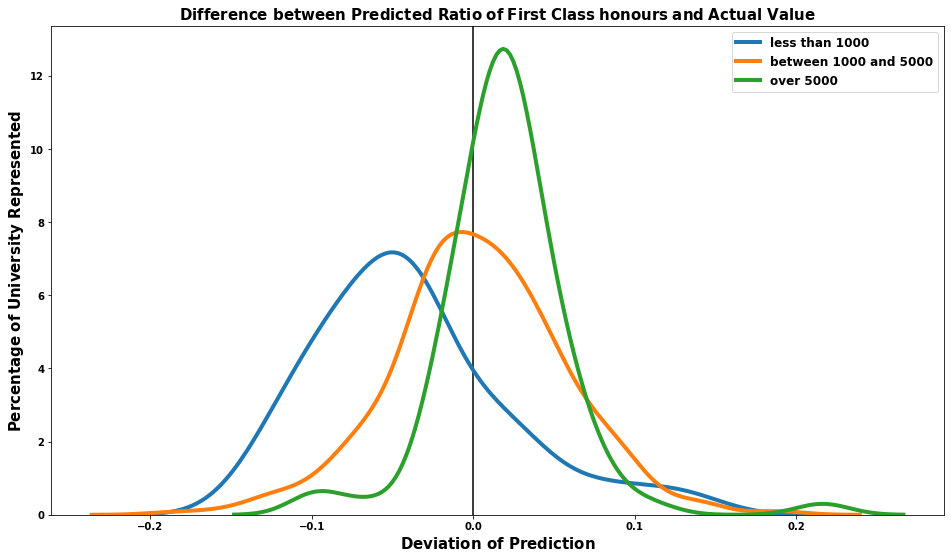

In [31]:
fig, ax = plt.subplots(figsize=(16,9))

plt.axvline(x=0,c='black')

for i,t in zip(range(len(tiers)), ['less than 1000', 'between 1000 and 5000', 'over 5000']):
    sns.distplot(tiers[i]['pred dev'], hist=False, kde_kws={"linewidth": 4}, label=t)

ax.set_title(r"$\mathbf{Difference \ between \ Predicted \ Ratio \; of \; First \; Class \; honours \; and \; Actual \ Value}$", fontsize=15)
ax.set_xlabel(r"$\mathbf{Deviation \ of \ Prediction}$", fontsize=15)
ax.set_ylabel(r"$\mathbf{Percentage \; of \; University \ Represented}$", fontsize=15)
ax.legend(prop={'size': 12})
rc('font', weight='bold')
plt.show()

NameError: name 'penguins' is not defined